In [172]:
# set up libraries + backend
from qiskit.tools.jupyter import * 
from qiskit import IBMQ
from qiskit import assemble
import numpy as np
import matplotlib.pyplot as plt
from qiskit import pulse
from qiskit.pulse import pulse_lib
from qiskit.pulse import Play
from qiskit.tools.monitor import job_monitor
from scipy.optimize import curve_fit
from scipy.interpolate import splrep, sproot, splev

%config InlineBackend.figure_format = 'svg' # cleans up backend

IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q', group='open', project='main')
backend = provider.get_backend('ibmq_armonk')

backend_config = backend.configuration()
assert backend_config.open_pulse, "Backend doesn't support OpenPulse"

# conversion factors
GHz = 1.0e9 
MHz = 1.0e6
kHz = 1.0e3
ms = 1.0e-3
us = 1.0e-6
ns = 1.0e-9 
scale_factor = 1e-14 

qubit = 0 # ground state qubit
dt = backend_config.dt # backend time-step

backend_defaults = backend.defaults()
qubit_props_dict = backend.properties().qubit_property(0)
rough_cavity_freq = backend_defaults.meas_freq_est[qubit]

# assign measurement map
meas_map_idx = None
for i, measure_group in enumerate(backend_config.meas_map):
    if qubit in measure_group:
        meas_map_idx = i
        break
assert meas_map_idx is not None, f"Couldn't find qubit {qubit} in the meas_map!"
qubit_meas_group = backend_config.meas_map[meas_map_idx]
inst_sched_map = backend_defaults.instruction_schedule_map
measure = inst_sched_map.get('measure', qubits=qubit_meas_group)

# assign experiment channels
drive_chan = pulse.DriveChannel(qubit)
meas_chan = pulse.MeasureChannel(qubit)
acq_chan = pulse.AcquireChannel(qubit)

# define for convenience
def get_closest_multiple_of_16(num):
    return int(num + 8 ) - (int(num + 8 ) % 16)

ibmqfactory.load_account:WARNING:2020-07-19 19:08:40,737: Credentials are already in use. The existing account in the session will be replaced.


In [173]:
# Define measurement, acquisition, cavity parameters
num_shots = 1024 # used in schedule later
meas_amp = 0.3
acq_samp_us = 0.2
meas_sigma_us = 0.01
meas_risefall_us = 0.01

acq_samp = get_closest_multiple_of_16(acq_samp_us * us/dt)
meas_sigma = get_closest_multiple_of_16(meas_sigma_us * us/dt)
meas_risefall = get_closest_multiple_of_16(meas_risefall_us * us/dt)
meas_pulse = pulse_lib.gaussian_square(duration=acq_samp, amp=meas_amp, sigma=meas_sigma, risefall=meas_risefall)

# Make measurement schedule
meas_schedule = pulse.Schedule(name="Measurement")
meas_schedule += Play(meas_pulse, meas_chan)
meas_schedule += pulse.Acquire(duration=acq_samp, 
                               channel=[pulse.AcquireChannel(i) for i in qubit_meas_group],
                               mem_slot=[pulse.MemorySlot(i) for i in qubit_meas_group])
acq_pulse = pulse.Acquire(duration=acq_samp, 
                               channel=[pulse.AcquireChannel(i) for i in qubit_meas_group],
                               mem_slot=[pulse.MemorySlot(i) for i in qubit_meas_group])

In [174]:
# Design cavity pulse
cav_dur_us = 3.0
cav_dur = get_closest_multiple_of_16(cav_dur_us * us/dt)
cavity_pulse = pulse_lib.gaussian_square(duration=cav_dur, amp = meas_amp, 
                                    sigma=meas_sigma, risefall=meas_risefall)

In [175]:
# Define pi pulse
pi_data = load_data('pipulse.txt')
pi_amp = pi_data["pi_amp"] # from calibration experiment
drive_sigma_us = pi_data["drive_sigma_us"] # Width of the gaussian pulse
drive_samps_us = pi_data["drive_samps_us"] # Truncates duration of gaussian to be finite

drive_sigma = get_closest_multiple_of_16(drive_sigma_us * us /dt)       # Puts width in units of dt
drive_samps = get_closest_multiple_of_16(drive_samps_us * us /dt)   # Puts duration in units of dt

mod_pi_pulse = pulse_lib.gaussian(duration=drive_samps, amp=pi_amp, 
                              sigma=drive_sigma, name='pi_pulse') # build pulse based on amp found

default_pi_pulse = inst_sched_map.get('x', qubit_meas_group) # this already has a channel too

In [176]:
# Define curve fitting function, allow for large number of max calls due to variety of plots from jobs
def fit_function(x_values, y_values, function, init_params):
    fitparams, conv = curve_fit(function, x_values, y_values, init_params, maxfev=300000) 
    y_fit = function(x_values, *fitparams)
    return fitparams, y_fit

# Stores squared abs value of complex data points returned from job
def get_results(job):
    result = job.result(timeout=120)
    sweep = []
    for i in range(len(result.results)):
        res = result.get_memory(i)[qubit]*scale_factor
        norm = np.real(res*np.conjugate(res))
        sweep.append(norm)
    return sweep

In [233]:
# Perform several experiments to get statistics --> define helper function
def gnd_exc_sweeps(central_freq_Hz, freq_span_Hz, num_samps):
    # build frequency array based on central freq (argument passed)
    half_samps = int(num_samps / 2)
    freq_min = central_freq_Hz - freq_span_Hz / 2
    freq_max = central_freq_Hz + freq_span_Hz / 2
    freq_Hz_tot = np.linspace(freq_min, freq_max, num_samps, endpoint=False)
    freq_Hz_left = freq_Hz_tot[:half_samps] # construct 1 array for each half
    freq_Hz_right = freq_Hz_tot[half_samps:]
    
    freq_GHz = freq_Hz_tot / GHz
    
    # Create schedule freqs
    schedule_freq_left = [{meas_chan: freq} for freq in freq_Hz_left]
    schedule_freq_right = [{meas_chan: freq} for freq in freq_Hz_right]
    
    # Define gnd schedule
    gnd_schedule = pulse.Schedule()
    gnd_schedule += Play(cavity_pulse, meas_chan) << drive_samples
    gnd_schedule += meas_schedule
    
    # Define exc schedule
    exc_schedule = pulse.Schedule();
    exc_schedule += Play(mod_pi_pulse, drive_chan)
    exc_schedule += Play(cavity_pulse, meas_chan) << drive_samples
    exc_schedule += meas_schedule
    
    gnd_program_left = assemble(gnd_schedule,
                            backend=backend, meas_level=1,
                            meas_return='avg', shots=num_shots,
                            schedule_los=schedule_freq_left)
    gnd_program_right = assemble(gnd_schedule,
                            backend=backend, meas_level=1,
                            meas_return='avg', shots=num_shots,
                            schedule_los=schedule_freq_right)
    
    exc_program_left = assemble(exc_schedule,
                            backend=backend, meas_level=1,
                            meas_return='avg', shots=num_shots,
                            schedule_los=schedule_freq_left)
    exc_program_right = assemble(exc_schedule,
                            backend=backend, meas_level=1,
                            meas_return='avg', shots=num_shots,
                            schedule_los=schedule_freq_right)
    
    gnd_job_left = backend.run(gnd_program_left)
    print(f"Left gnd job running")
    job_monitor(gnd_job_left)
    gnd_data_left = get_results(gnd_job_left)
    
    gnd_job_right = backend.run(gnd_program_right)
    print(f"Right gnd job running")
    job_monitor(gnd_job_right)
    gnd_data_right = get_results(gnd_job_right)
    
    exc_job_left = backend.run(exc_program_left)
    print(f"Left exc job is running")
    job_monitor(exc_job_left)
    exc_data_left = get_results(exc_job_left)
    
    exc_job_right = backend.run(exc_program_right)
    print(f"Right exc job is running")
    job_monitor(exc_job_right)
    exc_data_right = get_results(exc_job_right)
    
    # Add each pair of datasets into 1 array to join the halves
    gnd_data = np.concatenate((gnd_data_left, gnd_data_right))
    exc_data = np.concatenate((exc_data_left, exc_data_right))
    
    # Fit total data
    ground_params, ground_fit = fit_function(freq_GHz, gnd_data, 
         lambda x, A, mod_qubit_freq, B, C: (A / np.pi) * (B / ((x - mod_qubit_freq)**2 + B**2)) + C,
        [10, rough_cavity_freq / GHz, 1, 0]) # initial parameters for curve_fit
    _, gnd_freq, _, _ = ground_params
    
    excited_params, excited_fit = fit_function(freq_GHz, exc_data,
         lambda x, A, mod_qubit_freq, B, C: (A / np.pi) * (B / ((x - mod_qubit_freq)**2 + B**2)) + C,
        [10, rough_cavity_freq / GHz, 1, 0]) # initial parameters for curve_fit
    _, exc_freq, _, _ = excited_params
    
    chi_GHz = (gnd_freq - exc_freq) / 2
    chi_Hz = chi_GHz * GHz
    return chi_Hz

In [204]:
# test helper function with approximate parameters
sample_gnd, sample_exc = gnd_exc_sweeps(rough_cavity_freq - 0.0004 * GHz, 2.0 * MHz, 80)

Left gnd job running
Job Status: job has successfully run
Right gnd job running
Job Status: job has successfully run
Left exc job is running
Job Status: job has successfully run
Right exc job is running
Job Status: job has successfully run


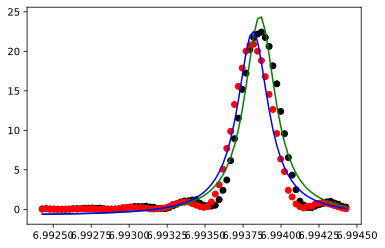

In [232]:
# build the specific freq array used by the job (just to check out plot)
num_samps = 80
central_freq_Hz = rough_cavity_freq - 0.0004
freq_span_Hz = 2.0 *MHz
freq_min = central_freq_Hz - freq_span_Hz / 2
freq_max = central_freq_Hz + freq_span_Hz / 2
freq_Hz = np.linspace(freq_min, freq_max, num_samps, endpoint=True)
freq_GHz = freq_Hz / GHz

# Fit total data
ground_params, ground_fit = fit_function(freq_GHz, sample_gnd, 
         lambda x, A, mod_qubit_freq, B, C: (A / np.pi) * (B / ((x - mod_qubit_freq)**2 + B**2)) + C,
        [10, rough_cavity_freq / GHz, 1, 0]) # initial parameters for curve_fit
_, grd_freq, _, _ = ground_params

# Fit total exc data
excited_params, excited_fit = fit_function(freq_GHz, sample_exc,
         lambda x, A, mod_qubit_freq, B, C: (A / np.pi) * (B / ((x - mod_qubit_freq)**2 + B**2)) + C,
        [10, rough_cavity_freq / GHz, 1, 0]) # initial parameters for curve_fit
_, exc_freq, _, _ = excited_params

# Plot raw and fitted data to make sure curvefits work
plt.scatter(freq_GHz, sample_gnd, color='black')
plt.scatter(freq_GHz, sample_exc, color='red')
plt.plot(freq_GHz, ground_fit, color='green')
plt.plot(freq_GHz, excited_fit, color='blue')
plt.show()

In [197]:
# sample chi
(grd_freq - exc_freq) / 2

2.1123314378090896e-05

In [234]:
chis = []

# Build array of central frequencies to test, see how estimate of chi will change
step_size = 1 * kHz
num_tries = 20
freq_min_trial = rough_cavity_freq - 0.5 * num_tries * step_size
freq_max_trial = rough_cavity_freq + 0.5 * num_tries * step_size
testing_freqs = np.linspace(freq_min_trial, freq_max_trial, num_tries, endpoint=False)

# Specify other parameters
freq_span = 1 * MHz
num_samps_per_trial = 80

# Run sweeps for testing_freqs
for freq in testing_freqs:
    chi = gnd_exc_sweeps(freq, freq_span, num_samps_per_trial)
    chis.append(chi)

Left gnd job running
Job Status: job has successfully run
Right gnd job running
Job Status: job has successfully run
Left exc job is running
Job Status: job has successfully run
Right exc job is running
Job Status: job has successfully run
Left gnd job running
Job Status: job has successfully run
Right gnd job running
Job Status: job has successfully run
Left exc job is running
Job Status: job has successfully run
Right exc job is running
Job Status: job has successfully run
Left gnd job running
Job Status: job has successfully run
Right gnd job running
Job Status: job has successfully run
Left exc job is running
Job Status: job has successfully run
Right exc job is running
Job Status: job has successfully run
Left gnd job running
Job Status: job has successfully run
Right gnd job running
Job Status: job has successfully run
Left exc job is running
Job Status: job has successfully run
Right exc job is running
Job Status: job has successfully run
Left gnd job running
Job Status: job has

In [238]:
# Perform statistics on chi
mean_chi = np.mean(chis)
stdev_chi = np.std(chis)
print(f"Chi has mean {mean_chi / kHz} kHz with standard deviation {stdev_chi / kHz} kHz")

Chi has mean 21.21652498197069 kHz with standard deviation 2.5258137083387107 kHz


In [1]:
# Save + store data externally

mean_chi_kHz = 21.21652498197069
stdev_chi_kHz = 2.5258137083387107
this_data = {'chi_kHz': mean_chi_kHz, 'stdev_kHz': stdev_chi_kHz}

import json 
filehandler = open('DispersionStats.txt', 'w')
json.dump(this_data, filehandler)
filehandler.close()